# Modification of Santa's 2019 Starter Notebook for Genetic Algorithm method

## Import

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os

In [800]:
# The name of the kernel might change, so update this if needed
from santa_s_2019_faster_cost_function_24_s import build_cost_function

## Definitions

In [360]:
# Paths to folders/files
#PATH_INPUT = '/kaggle/input' #for kaggle
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"
PATH_BASELINE_0 = PATH_TO_SAVE_DATA + '/df_fake_news.pkl'
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'
PATH_SAVE_DF_POP = PATH_TO_SAVE_DATA + '/df_pop.pkl'
PATH_SAVE_DF_POP_10 = PATH_TO_SAVE_DATA + '/df_pop_10.pkl'
# Data information
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

# Hyper-parameters:
NB_FIRST_POP = 1000 # number of first population of choices 
R_FIRST_MUT = 0.01 # RATIO of mutation for first population
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
NB_MAX_EPOCHS = 1000
# method 2 : by choices
DELTA_CHOICE = 1
CHOICE_RANGE_MIN = 0
CHOICE_RANGE_MAX = 10

In [26]:
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [803]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice

def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]
    
def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]
    #try:
    #    return idx_choice_curr[0]
    #except:
    #    return 10 
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day_arr(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("choice_new: ", choice_new)
    return choose_day_prob_arr(choice_new, fam_id)

def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [627]:
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    list_days.append(mutation_day(day_curr, fam_id, 1, True))
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.2276010513305664


In [628]:
nb_mut = 1
vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
t_fit_0 = time.time()
for I in range(0,1000):
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)
    choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.08911991119384766


In [514]:
choice_new

array([8])

In [560]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  1.0702500343322754


In [704]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_from_day(day_curr, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.7267796993255615


In [705]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_from_day_arr(day_curr, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.004541873931884766


In [516]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_range(choice_curr)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.05540800094604492


In [517]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

Timing 1:  0.9553639888763428
Timing 2:  0.05506300926208496
[0.58935396 0.32748678 0.08315927]
Timing Tot:  1.0112509727478027


In [518]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

Timing 1:  0.022983789443969727
Timing 2:  0.05568528175354004
[0.58935396 0.32748678 0.08315927]
Timing Tot:  0.0793609619140625


In [501]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
        day_new = choose_day_prob(choice_new, fam_id)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)

    
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

Timing 1:  0.044342756271362305
Timing 2:  6.729721784591675
[0.58935396 0.32748678 0.08315927]
Timing Tot:  6.77520489692688


In [543]:

arr_choice = np.array(data_choice)

def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    #fam_days = arr_choice[fam_id,:]
    #idx_choice_curr = fam_days[day_curr == fam_days].index
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

find_choice_from_day_arr(52, 0)

0

In [542]:
find_choice_from_day(52, 0)

0

In [537]:
def test_fun():
    day_curr = 28
    print(arr_choice[0,:])
    print(arr_choice[0,:] == day_curr)
    idx_choice_curr = np.nonzero(arr_choice[0,:] == day_curr)[0]
    if idx_choice_curr.shape[0] == 0:
        print( 10 )
    else:
        print(idx_choice_curr[0])
test_fun()

[52 38 12 82 33 75 64 76 10 28]
[False False False False False False False False False  True]
9


In [594]:
def choose_day_prob_arr(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = arr_choice[fam_id, np.minimum(9, choice_curr)]
    #vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum()
        #np.array(df_prob_fam.astype("float").loc[fam_id])/ \
        #    df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice

In [616]:
arr_prob_fam

array([[0.0005622493925075625, 0.003601384813138141,
        0.0018031885147012706, ..., 0.011430757420962185,
        0.012248777726040456, 0.01089464149502091],
       [0.0005622493925075624, 0.0036013848131381397,
        0.00180318851470127, ..., 0.011430757420962182,
        0.012248777726040452, 0.010894641495020906],
       [0.0005651831685057599, 0.003620176574349186,
        0.0018125974198155337, ..., 0.011490402272890388,
        0.012312690947786496, 0.06371996048909999],
       ...,
       [0.0005560968403363412, 0.0035619757746460654,
        0.04861969533904561, ..., 0.011305673548349375,
        0.012114742465180402, 0.010775424202698149],
       [0.04971635799589922, 0.003581994241755283, 0.0017934797894677132,
        ..., 0.01136921195186299, 0.01218282787308859,
        0.010835982580586333],
       [0.0005622493925075625, 0.0036013848131381406,
        0.0018031885147012704, ..., 0.011430757420962183,
        0.012248777726040456, 0.010894641495020908]], dtype=obje

In [568]:
arr_choice[fam_id, np.minimum(9, choice_curr)]

40

In [570]:
data_choice.loc[fam_id, np.minimum(9, choice_curr)]

40

In [603]:
choice_new = np.array([8])

In [623]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob_arr(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.01995372772216797


In [624]:
choose_day_prob_arr(choice_new, fam_id)

array([17])

In [625]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.8176393508911133


In [626]:
choose_day_prob(choice_new, fam_id)

array([17])

In [529]:
day_curr

100

In [584]:
arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum() \
-np.array(df_prob_fam.astype("float").loc[fam_id])/df_prob_fam.loc[fam_id].sum()

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [581]:
np.array(df_prob_fam.astype("float").loc[fam_id])/df_prob_fam.loc[fam_id].sum()

array([0.00055287, 0.0035413 , 0.0017731 , 0.05789391, 0.00163696,
       0.00392608, 0.00345707, 0.00367562, 0.00351792, 0.00166943,
       0.00169017, 0.00168482, 0.00353347, 0.00378213, 0.00375328,
       0.00389026, 0.04872893, 0.00172527, 0.00171188, 0.00374668,
       0.00397983, 0.00372703, 0.00377321, 0.05422746, 0.00169644,
       0.00164623, 0.00384813, 0.00374011, 0.00360721, 0.00536542,
       0.00190572, 0.00192348, 0.00188883, 0.0057931 , 0.00509608,
       0.00597718, 0.00582476, 0.05218531, 0.0558344 , 0.02814493,
       0.00468541, 0.00569002, 0.00541999, 0.00526819, 0.00189274,
       0.00190062, 0.00185218, 0.00517861, 0.00531636, 0.00566482,
       0.00508393, 0.00191944, 0.0573929 , 0.00192929, 0.06069169,
       0.0057411 , 0.00575143, 0.00490459, 0.00189163, 0.00229726,
       0.05394504, 0.00935027, 0.01220531, 0.01125983, 0.01266452,
       0.00222533, 0.00228414, 0.002442  , 0.01043325, 0.01156525,
       0.01246703, 0.01124004, 0.0022752 , 0.00242717, 0.00224

In [521]:
data_choice

,0,1,2,3,4,5,6,7,8,9
family_id,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28
1,26,4,82,5,11,47,38,6,66,61
2,100,54,25,12,27,82,10,89,80,33
3,2,95,1,96,32,6,40,31,9,59
4,53,1,47,93,26,3,46,16,42,39
5,32,59,12,3,60,26,35,50,5,2
6,88,4,1,3,91,32,39,57,28,99
7,25,11,52,48,10,17,88,50,95,66
8,18,60,1,12,89,33,16,10,53,67


In [520]:
arr_choice = np.array(data_choice)
arr_choice

array([[ 52,  38,  12, ...,  76,  10,  28],
       [ 26,   4,  82, ...,   6,  66,  61],
       [100,  54,  25, ...,  89,  80,  33],
       ...,
       [ 32,  66,  54, ...,  81,   3,   7],
       [ 67,  92,   4, ...,  12,  26,  70],
       [ 13,  11,  25, ...,  39,  18,  47]])

In [502]:
nb_mut

9

In [478]:
vect_prob

[0.1, 0.03]

In [473]:
np.array(range_choices)

array([ 8,  9, 10])

In [474]:
df_prob

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.100491,0.099238,0.098787,0.097535,0.095030,0.094580,0.092075,0.091173,0.088669,0.076195,0.066227
3,0.102556,0.101278,0.100588,0.099310,0.096753,0.096063,0.093507,0.092127,0.089571,0.071754,0.056494
4,0.104708,0.103403,0.102463,0.101158,0.098549,0.097609,0.094999,0.093120,0.090511,0.067127,0.046353
5,0.106952,0.105619,0.104419,0.103087,0.100421,0.099221,0.096556,0.094156,0.091491,0.062301,0.035777
6,0.109294,0.107932,0.106461,0.105099,0.102375,0.100904,0.098180,0.095238,0.092514,0.057264,0.024738
7,0.111742,0.110349,0.108594,0.107202,0.104417,0.102662,0.099877,0.096368,0.093583,0.052001,0.013205
8,0.114301,0.112877,0.110825,0.109401,0.106552,0.104501,0.101652,0.097550,0.094701,0.046497,0.001143


In [461]:
arr_prob = np.array(df_prob)
arr_prob[0,0]

0.10049061278022005

In [468]:
family_size_dict[0]

4

In [476]:
arr_prob[family_size_dict[0]-2,range_choices]

array([0.09051051, 0.06712683, 0.04635294])

In [458]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [622]:
arr_prob_fam = np.array(df_prob_fam.astype("float"))
arr_prob_fam

array([[0.00056225, 0.00360138, 0.00180319, ..., 0.01143076, 0.01224878,
        0.01089464],
       [0.00056225, 0.00360138, 0.00180319, ..., 0.01143076, 0.01224878,
        0.01089464],
       [0.00056518, 0.00362018, 0.0018126 , ..., 0.0114904 , 0.01231269,
        0.06371996],
       ...,
       [0.0005561 , 0.00356198, 0.0486197 , ..., 0.01130567, 0.01211474,
        0.01077542],
       [0.04971636, 0.00358199, 0.00179348, ..., 0.01136921, 0.01218283,
        0.01083598],
       [0.00056225, 0.00360138, 0.00180319, ..., 0.01143076, 0.01224878,
        0.01089464]])

In [578]:
df_prob_fam.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
family_id,,,,,,,,,,,,,,,,,,,,,
0,0.000562249,0.00360138,0.00180319,0.00167978,0.00166473,0.0039927,0.00351573,0.00373799,0.00357761,0.0480268,...,0.00992993,0.0121119,0.013522,0.00232124,0.00229422,0.00223432,0.0120446,0.0114308,0.0122488,0.0108946
1,0.000562249,0.00360138,0.00180319,0.0546079,0.053444,0.0516575,0.00351573,0.00373799,0.00357761,0.00169776,...,0.00992993,0.0121119,0.013522,0.00232124,0.00229422,0.00223432,0.0120446,0.0114308,0.0122488,0.0108946
2,0.000565183,0.00362018,0.0018126,0.00168854,0.00167342,0.00401353,0.00353408,0.00375749,0.00359628,0.0498192,...,0.00998174,0.0121751,0.0135926,0.00233335,0.00230619,0.00224598,0.0121075,0.0114904,0.0123127,0.06372
3,0.0516533,0.0556045,0.00182172,0.00169704,0.00168184,0.0529431,0.00355186,0.0037764,0.049467,0.0017152,...,0.010032,0.0122364,0.013661,0.00234509,0.0536363,0.052695,0.0121684,0.0115482,0.0123747,0.0110066
4,0.0534904,0.00360138,0.0517657,0.00167978,0.00166473,0.0039927,0.00351573,0.00373799,0.00357761,0.00169776,...,0.00992993,0.0121119,0.0653013,0.00232124,0.00229422,0.00223432,0.0120446,0.0114308,0.0122488,0.0108946


## Read in the family information and sample submission

In [778]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
# patch for optimization
arr_choice = np.array(data_choice)
data_choice.head()


,0,1,2,3,4,5,6,7,8,9
family_id,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28
1,26,4,82,5,11,47,38,6,66,61
2,100,54,25,12,27,82,10,89,80,33
3,2,95,1,96,32,6,40,31,9,59
4,53,1,47,93,26,3,46,16,42,39


In [29]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [30]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [31]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [801]:
# Build your "cost_function"
cost_function_optim = build_cost_function(data)

In [804]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

In [784]:
list_p0 = np.array([0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500])
list_pn = np.array([0, 0, 9, 9, 9, 18, 18, 36, 36, 36+199, 36+398])

In [785]:
def cost_function_arr(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        #list_choice = np.array(list_choice)
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        
        if d == choice_0:
            idx_choice = 0
        elif d == choice_1:
            idx_choice = 1
        elif d == choice_2:
            idx_choice = 2
        elif d == choice_3:
            idx_choice = 3
        elif d == choice_4:
            idx_choice = 4
        elif d == choice_5:
            idx_choice = 5
        elif d == choice_6:
            idx_choice = 6
        elif d == choice_7:
            idx_choice = 7
        elif d == choice_8:
            idx_choice = 8
        elif d == choice_9:
            idx_choice = 9
        else:
            idx_choice = 10
        
       # print(idx_choice)
        penalty += list_p0[idx_choice] + n * list_pn[idx_choice]
        

        
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

In [742]:
a=[1,2,3]
a.index(3)

2

In [786]:
cost_function_arr(submission['assigned_day'], True)

penalty for only families:  10639591
daily_occupancy:  {100: 206, 99: 203, 98: 209, 97: 204, 96: 233, 95: 203, 94: 210, 93: 197, 92: 207, 91: 237, 90: 211, 89: 220, 88: 212, 87: 204, 86: 203, 85: 211, 84: 214, 83: 209, 82: 211, 81: 232, 80: 204, 79: 226, 78: 217, 77: 211, 76: 208, 75: 199, 74: 213, 73: 203, 72: 223, 71: 218, 70: 210, 69: 207, 68: 197, 67: 189, 66: 203, 65: 204, 64: 219, 63: 222, 62: 205, 61: 227, 60: 211, 59: 195, 58: 215, 57: 198, 56: 201, 55: 210, 54: 213, 53: 213, 52: 199, 51: 212, 50: 214, 49: 199, 48: 205, 47: 207, 46: 226, 45: 203, 44: 224, 43: 208, 42: 209, 41: 220, 40: 201, 39: 214, 38: 207, 37: 196, 36: 212, 35: 203, 34: 204, 33: 199, 32: 233, 31: 225, 30: 211, 29: 206, 28: 228, 27: 201, 26: 217, 25: 207, 24: 209, 23: 198, 22: 214, 21: 209, 20: 216, 19: 201, 18: 188, 17: 212, 16: 200, 15: 206, 14: 210, 13: 205, 12: 192, 11: 216, 10: 237, 9: 207, 8: 214, 7: 207, 6: 198, 5: 221, 4: 217, 3: 206, 2: 230, 1: 203}
accounting_cost:  1907.4031350226594


10641498.403135022

In [790]:
cost_function(df_pop.loc[indice].tolist(), True)

penalty for only families:  650287
daily_occupancy:  {100: 126, 99: 125, 98: 127, 97: 128, 96: 170, 95: 213, 94: 245, 93: 130, 92: 119, 91: 125, 90: 134, 89: 179, 88: 208, 87: 205, 86: 132, 85: 121, 84: 125, 83: 127, 82: 158, 81: 192, 80: 217, 79: 125, 78: 127, 77: 129, 76: 136, 75: 191, 74: 205, 73: 205, 72: 126, 71: 125, 70: 126, 69: 125, 68: 173, 67: 209, 66: 239, 65: 132, 64: 125, 63: 128, 62: 132, 61: 171, 60: 212, 59: 234, 58: 194, 57: 145, 56: 164, 55: 163, 54: 207, 53: 236, 52: 252, 51: 217, 50: 175, 49: 201, 48: 225, 47: 249, 46: 269, 45: 252, 44: 216, 43: 165, 42: 182, 41: 207, 40: 224, 39: 261, 38: 243, 37: 215, 36: 163, 35: 195, 34: 211, 33: 250, 32: 284, 31: 266, 30: 252, 29: 243, 28: 250, 27: 268, 26: 298, 25: 300, 24: 301, 23: 263, 22: 246, 21: 238, 20: 239, 19: 278, 18: 290, 17: 292, 16: 264, 15: 268, 14: 295, 13: 300, 12: 300, 11: 300, 10: 300, 9: 277, 8: 282, 7: 258, 6: 252, 5: 278, 4: 292, 3: 294, 2: 284, 1: 289}
accounting_cost:  25473.74413709682


300675760.7441371

In [802]:
cost_function_optim(df_pop.loc[indice].tolist())

100025465.18741842

In [787]:
cost_function(submission['assigned_day'].values)

10641498.403135022

In [788]:
cost_function_optim(submission['assigned_day'].values)



100001907.40313502

In [776]:
submission['assigned_day'].values

array([100,  99,  98, ...,   3,   2,   1])

In [777]:
submission['assigned_day']

family_id
0       100
1        99
2        98
3        97
4        96
5        95
6        94
7        93
8        92
9        91
10       90
11       89
12       88
13       87
14       86
15       85
16       84
17       83
18       82
19       81
20       80
21       79
22       78
23       77
24       76
25       75
26       74
27       73
28       72
29       71
       ... 
4970     30
4971     29
4972     28
4973     27
4974     26
4975     25
4976     24
4977     23
4978     22
4979     21
4980     20
4981     19
4982     18
4983     17
4984     16
4985     15
4986     14
4987     13
4988     12
4989     11
4990     10
4991      9
4992      8
4993      7
4994      6
4995      5
4996      4
4997      3
4998      2
4999      1
Name: assigned_day, Length: 5000, dtype: int64

In [683]:
for day in submission['assigned_day']:
    arr_fam_cost[n-2, find_choice_from_day_arr(day, 0)]

In [666]:
arr_fam_cost[n-2, find_choice_from_day_arr(51, 0)]

3972

In [781]:
# Run it on default submission file
best = submission['assigned_day'].values
start_score = cost_function(best)
start_score

100001907.40313502

In [771]:
def test_cost_time():
    for I in range(0,1000):
        cost_function(submission['assigned_day'].values)
%time test_cost_time()

CPU times: user 17 ms, sys: 1.12 ms, total: 18.1 ms
Wall time: 19.8 ms


In [765]:
def test_cost_arr_time():
    for I in range(0,1000):
        cost_function_arr(submission['assigned_day'])
%time test_cost_arr_time()

CPU times: user 13 s, sys: 258 ms, total: 13.2 s
Wall time: 15.3 s


In [644]:
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,0,50,68,118,218,236,336,372,472,970,1368,2
3,0,50,77,127,227,254,354,408,508,1205,1802,3
4,0,50,86,136,236,272,372,444,544,1440,2236,4
5,0,50,95,145,245,290,390,480,580,1675,2670,5
6,0,50,104,154,254,308,408,516,616,1910,3104,6
7,0,50,113,163,263,326,426,552,652,2145,3538,7
8,0,50,122,172,272,344,444,588,688,2380,3972,8


In [652]:
arr_fam_cost = np.array(df_fam_cost.filter(items=[f'choice_{i}' for i in range(11)]))
arr_fam_cost

array([[   0,   50,   68,  118,  218,  236,  336,  372,  472,  970, 1368],
       [   0,   50,   77,  127,  227,  254,  354,  408,  508, 1205, 1802],
       [   0,   50,   86,  136,  236,  272,  372,  444,  544, 1440, 2236],
       [   0,   50,   95,  145,  245,  290,  390,  480,  580, 1675, 2670],
       [   0,   50,  104,  154,  254,  308,  408,  516,  616, 1910, 3104],
       [   0,   50,  113,  163,  263,  326,  426,  552,  652, 2145, 3538],
       [   0,   50,  122,  172,  272,  344,  444,  588,  688, 2380, 3972]])

## Simple Opimization Approach : baseline #0

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [33]:
t_fit_0 = time.time()
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)
new = best.copy()
cost_best = start_cost
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        cost_curr = cost_function(temp) # test cost
        if cost_curr < cost_best:
            new = temp.copy()
            cost_best = cost_curr
            #print("Current best cost: ", cost_best)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022


KeyboardInterrupt: 

In [172]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# save for later use
joblib.dump(submission, PATH_BASELINE_0)


## Explore day occupancy

In [350]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

,all_choices,first_choices,mid_choices,last_choices
1,11568,4391,4449,2728
2,1806,501,729,576
3,3607,1021,1526,1060
4,3872,1148,1585,1139
5,3907,1181,1544,1182


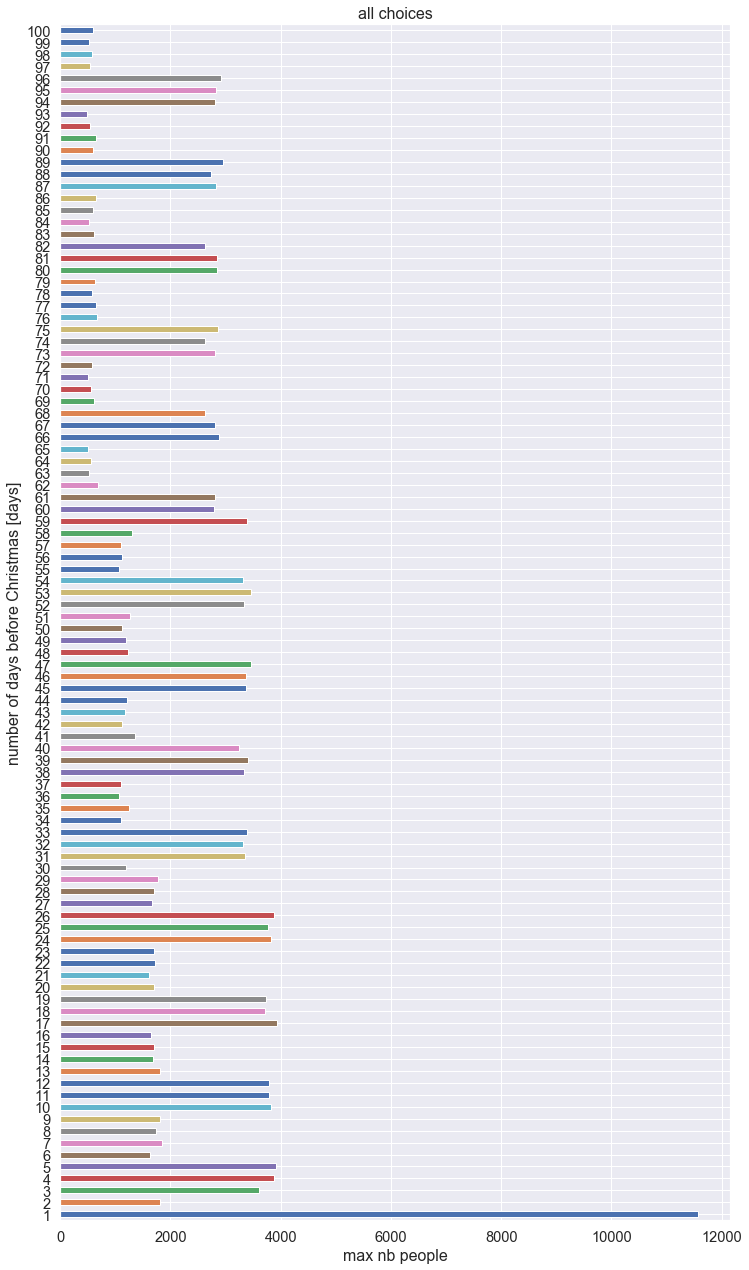

In [351]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

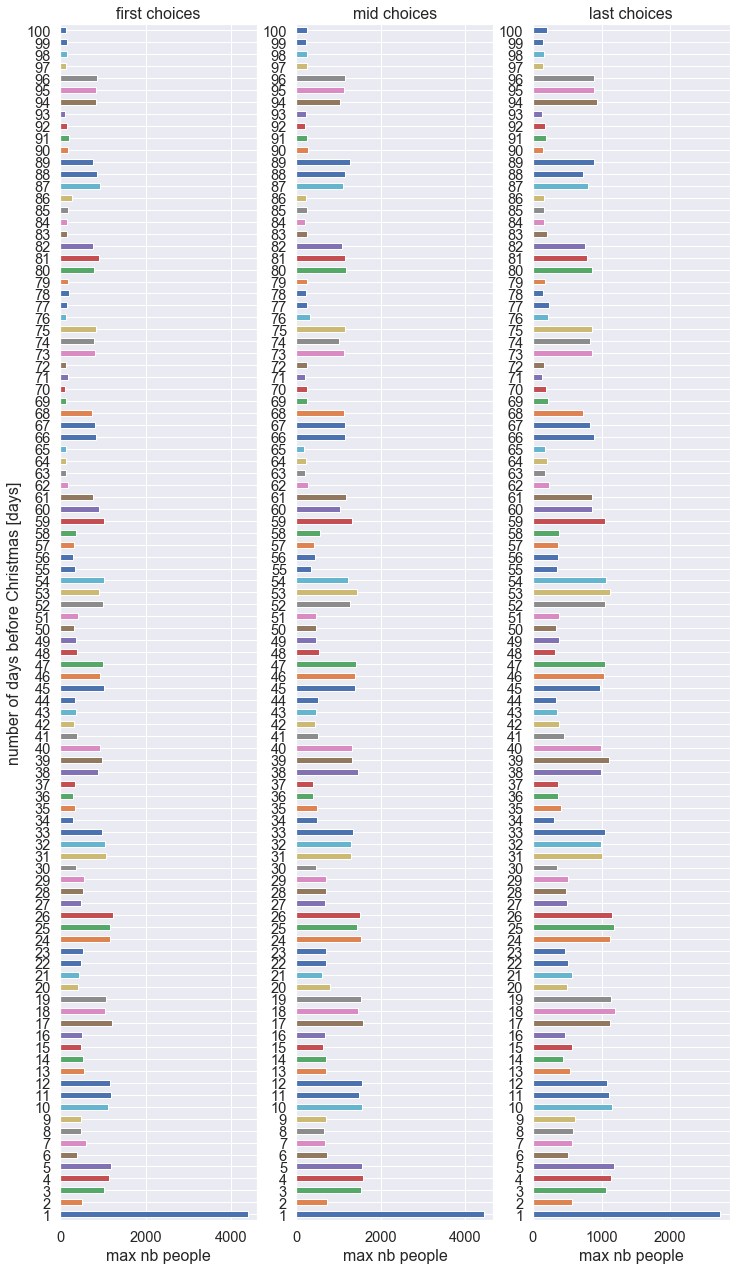

In [352]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [353]:
'''df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob'''

df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [354]:
df_prob_day.head()

,all_choices,prob
1,11568,0.001098
2,1806,0.007036
3,3607,0.003523
4,3872,0.003282
5,3907,0.003252


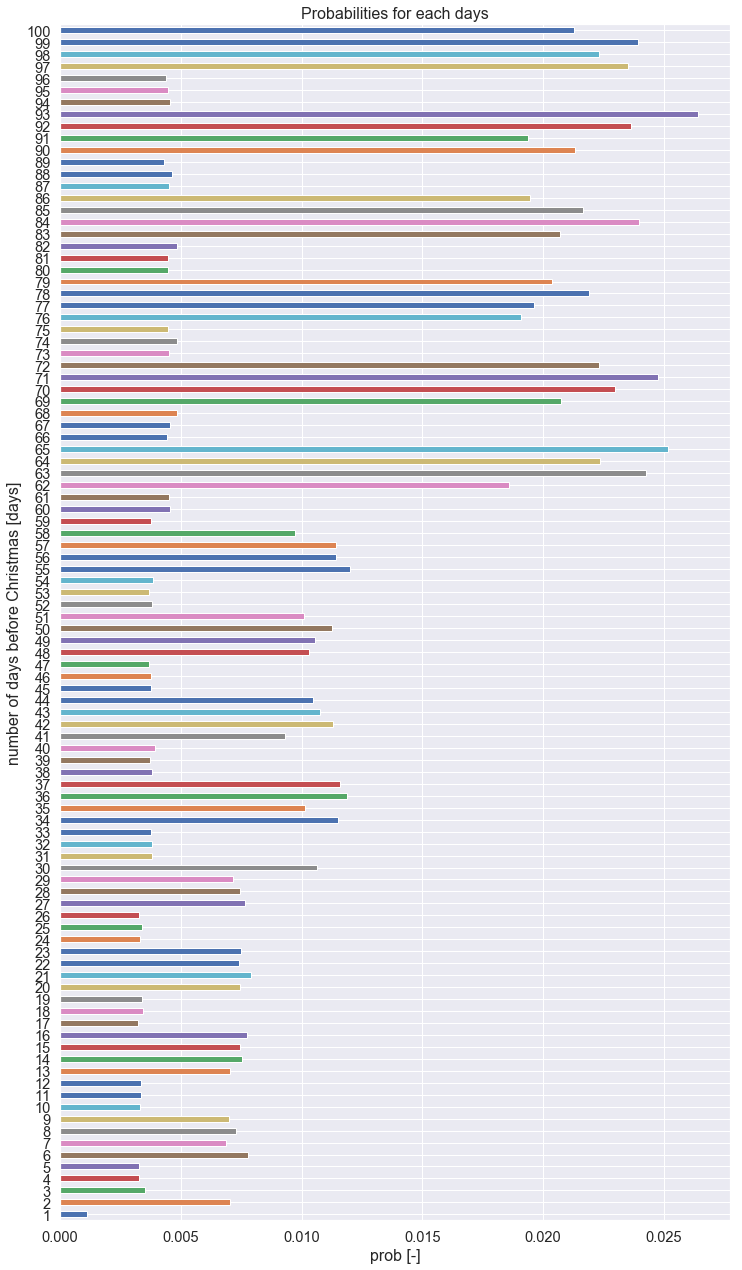

In [355]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [41]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

In [42]:
cost_family(choice=1, n=2)

50

### Evolution of cost by number of people into family

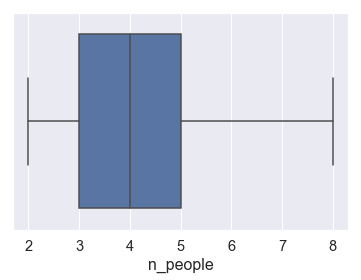

In [43]:
ax = sns.boxplot(x=data["n_people"])


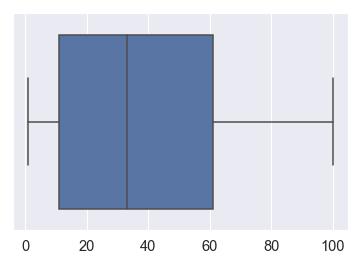

In [44]:
ax = sns.boxplot(data)

In [45]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [46]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,0,50,68,118,218,236,336,372,472,970,1368,2
3,0,50,77,127,227,254,354,408,508,1205,1802,3
4,0,50,86,136,236,272,372,444,544,1440,2236,4
5,0,50,95,145,245,290,390,480,580,1675,2670,5
6,0,50,104,154,254,308,408,516,616,1910,3104,6
7,0,50,113,163,263,326,426,552,652,2145,3538,7
8,0,50,122,172,272,344,444,588,688,2380,3972,8


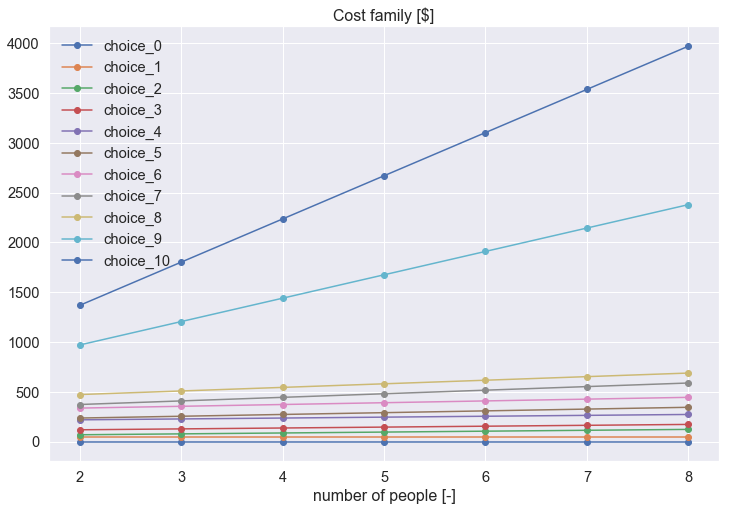

In [47]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

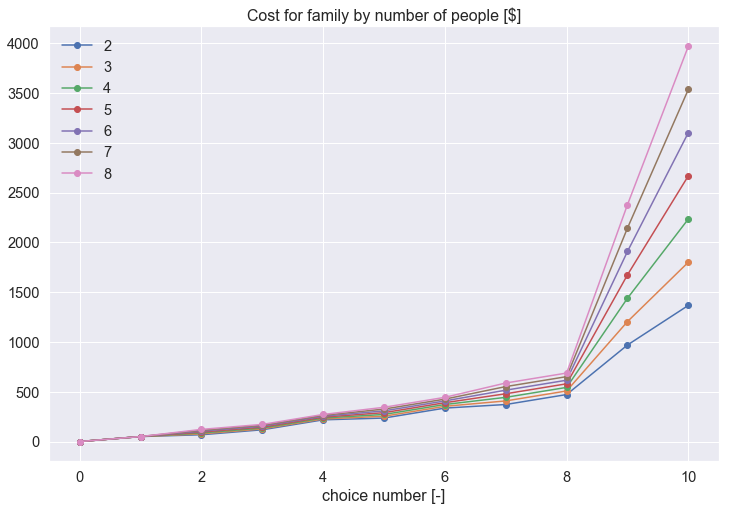

In [48]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [346]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1, ):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

    return df_prob  


#### p max = 0.1, p min = 0.03

In [336]:
df_prob = create_df_fam_cost_prob(df_fam_cost)
df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.097481,0.096622,0.096313,0.095454,0.093736,0.093427,0.091709,0.091090,0.089372,0.080817,0.073980
3,0.098846,0.097975,0.097505,0.096634,0.094892,0.094422,0.092680,0.091739,0.089997,0.077855,0.067455
4,0.100250,0.099367,0.098731,0.097848,0.096081,0.095445,0.093678,0.092406,0.090639,0.074809,0.060746
5,0.101695,0.100799,0.099992,0.099096,0.097304,0.096498,0.094705,0.093092,0.091300,0.071675,0.053843
6,0.103182,0.102272,0.101291,0.100381,0.098563,0.097581,0.095763,0.093799,0.091980,0.068450,0.046738
7,0.104713,0.103790,0.102627,0.101705,0.099859,0.098697,0.096851,0.094526,0.092681,0.065129,0.039423
8,0.106290,0.105353,0.104004,0.103068,0.101195,0.099846,0.097973,0.095275,0.093402,0.061708,0.031887


#### p max = 0.5, p min = 0.01

In [347]:
df_prob_2 = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob_2

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.100491,0.099238,0.098787,0.097535,0.095030,0.094580,0.092075,0.091173,0.088669,0.076195,0.066227
3,0.102556,0.101278,0.100588,0.099310,0.096753,0.096063,0.093507,0.092127,0.089571,0.071754,0.056494
4,0.104708,0.103403,0.102463,0.101158,0.098549,0.097609,0.094999,0.093120,0.090511,0.067127,0.046353
5,0.106952,0.105619,0.104419,0.103087,0.100421,0.099221,0.096556,0.094156,0.091491,0.062301,0.035777
6,0.109294,0.107932,0.106461,0.105099,0.102375,0.100904,0.098180,0.095238,0.092514,0.057264,0.024738
7,0.111742,0.110349,0.108594,0.107202,0.104417,0.102662,0.099877,0.096368,0.093583,0.052001,0.013205
8,0.114301,0.112877,0.110825,0.109401,0.106552,0.104501,0.101652,0.097550,0.094701,0.046497,0.001143


In [364]:

# save
joblib.dump(df_prob_2, PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

['../../data/df_prob_2.pkl']

## Creation of days probabilities by family

In [348]:
def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

In [359]:
df_prob_fam = create_df_prob_day_fam(df_prob_day, df_prob_2)
# save
joblib.dump(df_prob_fam, PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

['../../data/df_prob_fam_2.pkl']

In [358]:

'''df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
for fam_id in df_prob_fam.index:
    # give at first to each families the same day probabilities
    df_prob_fam.loc[fam_id] = df_prob_day["prob"]
    # and add prob for each day choosen by families
    for choice in list_choice_all: 
        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
        day_curr = data.at[fam_id, choice]
        # add this prob of these days to family into df_prob_fam
        df_prob_fam.loc[fam_id, day_curr] += prob_curr
        #print(day_curr)
        #print(prob_curr)
    df_prob_fam.loc[fam_id] = \
        df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    
     
    
df_prob_fam'''

'df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)\nfor fam_id in df_prob_fam.index:\n    # give at first to each families the same day probabilities\n    df_prob_fam.loc[fam_id] = df_prob_day["prob"]\n    # and add prob for each day choosen by families\n    for choice in list_choice_all: \n        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]\n        day_curr = data.at[fam_id, choice]\n        # add this prob of these days to family into df_prob_fam\n        df_prob_fam.loc[fam_id, day_curr] += prob_curr\n        #print(day_curr)\n        #print(prob_curr)\n    df_prob_fam.loc[fam_id] =         df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()\n    \n     \n    \ndf_prob_fam'

In [413]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data//df_prob_fam.pkl']

In [322]:
df_prob_fam.loc[0].plot()

NameError: name 'df_prob_fam' is not defined

## From Scratch

### Generate first population

In [381]:

np.random.choice(np.array(range(0, df_prob.shape[1])), size=1, 
                 p=df_prob.loc[2].values)

array([6])

In [165]:
data.loc[indice,"n_people"]

4

In [265]:
# df_choice : contains number choices of all the population of 5000 families
df_choice = pd.DataFrame()

# for each family, create n choice among their first choice
for indice in data.index:
    vect_pop = np.random.choice(np.array(range(0, df_prob.shape[1])), 
                            size=NB_FIRST_POP, 
                            p=df_prob.loc[data.loc[indice,"n_people"]].values)
    df_choice[indice] = vect_pop
df_choice.shape

(1000, 5000)

In [266]:
df_choice.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3,3,5,8,3,9,4,1,2,6,...,0,4,7,2,0,9,1,1,8,6
1,7,3,0,6,0,9,9,4,8,7,...,2,3,3,3,5,1,1,9,2,3
2,1,4,1,10,4,1,5,7,5,5,...,0,4,6,6,7,0,8,4,8,5
3,4,9,6,0,6,6,2,5,5,1,...,7,7,8,4,2,6,10,2,2,4
4,8,7,7,5,3,4,5,2,8,3,...,5,8,8,0,6,7,1,1,8,10


### Treatment of choices

In [301]:
# for choice number 10, choose a day among all days except choices 0 to 9 : 
# probability is choosen uniform

def choose_day(choice_curr, fam_id):
    if choice_curr == 10:
        vect_choices = list(range(1, 101))
        for indice in range(0, 10):
            vect_choices.remove(data.loc[fam_id, "choice_{}".format(indice)])    
        #print(vect_choices)
        return np.random.choice(vect_choices, size=1)[0]
    else:
        return data.at[fam_id, "choice_{}".format(choice_curr)]


In [268]:
df_pop = df_choice.copy()
for fam_id in df_pop.columns:
    df_pop[fam_id] = df_pop[fam_id].apply(choose_day, args=(fam_id,))
    
df_pop

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,82,5,82,9,93,2,91,11,1,96,...,47,83,32,89,52,60,66,66,26,96
1,76,5,100,40,53,2,99,10,53,47,...,74,1,90,66,87,1,66,7,4,80
2,38,11,54,54,26,59,32,50,33,18,...,47,83,76,81,47,16,59,27,26,40
3,33,61,10,2,46,35,1,17,33,88,...,94,14,1,28,1,56,42,54,4,88
4,10,6,89,6,93,60,32,52,53,50,...,46,91,1,62,16,46,66,66,26,22
5,52,5,27,96,39,26,57,88,1,39,...,5,49,52,1,13,33,81,54,12,39
6,38,40,27,59,1,32,99,11,1,28,...,61,75,32,1,47,56,24,74,53,39
7,33,97,25,93,3,59,88,17,33,96,...,74,29,1,40,54,66,17,66,53,80
8,75,11,80,6,46,78,4,88,18,39,...,4,47,66,88,54,33,91,66,17,96
9,52,11,25,32,93,12,57,48,12,18,...,32,83,22,81,1,16,88,23,70,39


### Evaluation of cost for all population

In [262]:
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

,cost
0,4.405331e+62
1,8.627548e+56
2,1.346244e+59
3,5.624646e+61
4,7.746507e+61
5,2.343082e+51
6,4.598295e+66
7,7.982710e+56
8,1.347359e+57
9,1.105799e+60


In [269]:
best = submission['assigned_day'].tolist()
len(best)

5000

In [335]:
cost_function(best)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

## From baseline #0

In [173]:
# reload 
submission = pd.read_csv('submission_672254.0276683343.csv')

In [558]:
# reload
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)

### Generate first population

Generation of 1000 "families choices" ensemble from baseline : 
- Number of individuals for first generation : NB_FIRST_POP
- Ratio of generation/mutation for first generation : R_FIRST_MUT
- delta around day choosen  : +/- DELTA_DAYS

Try to find fine tune these hyperparameters (I don't have method ! )

In [384]:
#submission = pd.read_csv('submission_672254.0276683343.csv')

In [654]:
# check baseline
cost_function(submission['assigned_day'])

10641498.403135022

In [81]:


find_day_range(50)

range(49, 52)

In [17]:
fam_id = 0
submission.at[fam_id, 'assigned_day']

52

In [ ]:
df_pop = generate_pop()
print("df_pop.shape: ", df_pop.shape)
df_pop.head()

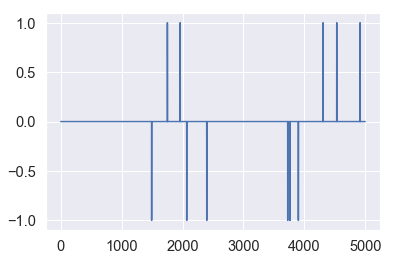

In [571]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

A effacer : 

In [83]:
# GENERATION OF FIRST POP:

# initialize with same previous best indiv.
df_pop = pd.DataFrame(index=range(0, NB_FIRST_POP), 
                      columns=submission["family_id"])

for fam_id in submission["family_id"]:
    df_pop[fam_id] = submission.at[fam_id,'assigned_day']

# create NB_FIRST_POP family choices from baseline :
# use probabilies
# df_pop : contains number choices of all the population of 5000 families
# df_pop = f(indiv., family)
# for each family, create n choice among their first choice
# use day probabilities specific for each family
for fam_id in data.index: # data = f(family, num choice)
    # day current is the old best submission day for this family
    day_curr = submission.at[fam_id, 'assigned_day']
    # find range around day curr +/- DELTA
    range_curr = find_day_range(day_curr)
    # retrict probabilities to range # df_prob_fam = f(fam_id, day)
    day_prob = df_prob_fam.astype("float").loc[fam_id,range_curr]/df_prob_fam.\
        loc[fam_id,range_curr].sum()
    # choose randomly with probabilities days around old best day
    vect_pop = np.random.choice(np.array(range_curr), 
                            size=NB_FIRST_POP, 
                            p=np.array(day_prob))
    
    # apply the new days only a part of pop : R_FIRST_MUT [-]
    range_mut = np.random.choice(range(0, NB_FIRST_POP), 
                                 size=int(R_FIRST_MUT*NB_FIRST_POP))
    
    #df_pop[fam_id] = submission['assigned_day']
    
    df_pop.loc[range_mut, fam_id] = vect_pop[range_mut]

# keep the best : 
df_pop.loc[0] = submission['assigned_day']

print("df_pop.shape: ", df_pop.shape)
df_pop.head()

df_pop.shape:  (1000, 5000)


family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
1,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
2,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
3,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
4,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


### Save pop

In [84]:
# save
joblib.dump(df_pop, PATH_SAVE_DF_POP)

['../../data//df_pop.pkl']

### Evaluation #1

In [570]:
# load 
df_pop = joblib.load(PATH_SAVE_DF_POP)

In [544]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

,cost
0,672254.027668
21,673249.435665
632,675341.022931
587,675579.598524
904,675800.361230
552,676043.157413
148,676060.161931
215,676639.495767
599,676960.819718
550,677205.766828


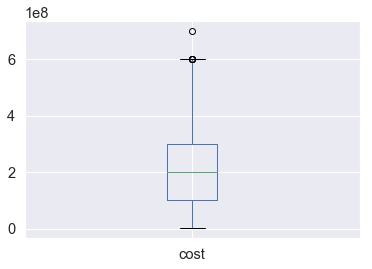

In [545]:
df_cost.boxplot()

### Loop over generations

In [546]:
# load 
#df_pop = joblib.load(PATH_SAVE_DF_POP)
#df_pop.shape

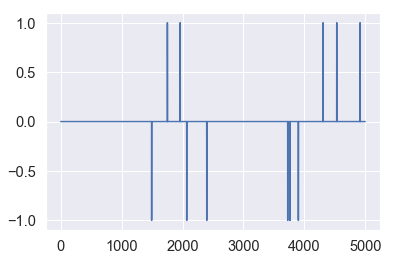

In [547]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

 
GENERATION #0 / nb. pop: 1000
nb_survivor:  990
              cost
990  672254.027668
991  673249.435665
21   675086.477112
238  675663.626834
743  675797.897188
Timing epoch:  13.22744607925415
 
GENERATION #1 / nb. pop: 992
nb_survivor:  982
              cost
982  672254.027668
983  673249.435665
302  675468.568847
303  675777.101886
561  676477.414141
Timing epoch:  13.66027307510376
 
GENERATION #2 / nb. pop: 984
nb_survivor:  974
              cost
0    672254.027668
974  672254.027668
975  673249.435665
805  674974.609299
845  675310.694047
Timing epoch:  12.444685935974121


Text(0, 0.5, 'cost [$]')

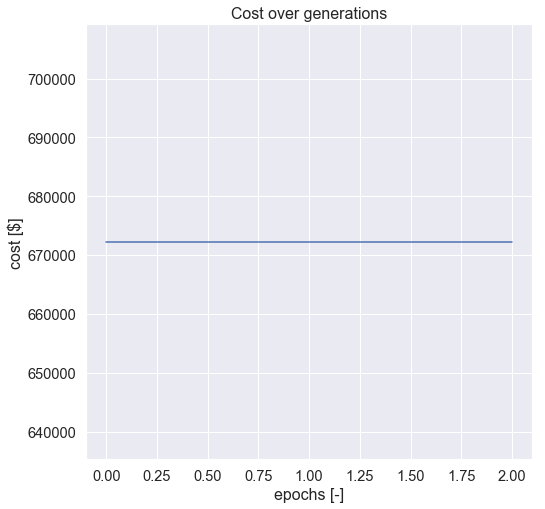

In [548]:
nb_seeds = 2 # number of seed sources : keep them along epochs
# LOOP OVER GENERATIONS 
list_best_cost = []
for gen_id in range(0, NB_MAX_EPOCHS):
    t_fit_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]
    # LOST WORST INDIV.

    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - nb_seeds)
    if (nb_survivor+nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))
    
    # check if previous best is still here
    #if name_best not in vect_survivor:
        # else replace by previous best
        #vect_survivor[0] = name_best

    df_pop = df_pop.loc[vect_survivor] 
    #df_pop_surv=df_pop.copy()

    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace first indiv
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)
    #df_pop_cross=df_pop.copy()

    # MUTATION
    # mutation of R_MUT * number of indiv 
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best 
    df_pop = df_pop.append(df_best, ignore_index=True)

    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 

    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(nb_seeds+3))
    
    t_fit_1 = time.time()
    print("Timing epoch: ", t_fit_1 - t_fit_0)
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

cost rankings:
[672254.0276683343, 673249.4356646903, 674728.7104080453, 675890.9699308008, 675979.8116211004]


In [518]:
list_name_best

[983, 314]

In [519]:
df_pop.loc[list_name_best]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,52.0,26.0,100.0,2.0,53.0,59.0,88.0,25.0,18.0,1.0,...,61.0,29.0,90.0,62.0,52.0,16.0,88.0,32.0,67.0,13.0


In [510]:

np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), vect_survivor))

array([990, 803, 867, 174, 379, 990, 193, 507, 142, 785, 631, 533, 422,
       203, 580, 977, 387,  20, 393, 612, 803, 505, 811, 359,  46, 461,
       944, 169, 775, 897, 467, 648, 976, 376, 518, 114, 741, 108, 181,
       768, 745, 330, 750, 705,  25, 163, 406, 736, 924,   5, 761,  40,
       430, 723, 876,  52, 879, 102, 820, 899, 516, 374, 337, 249, 302,
       559, 950, 759, 217, 920, 546, 550, 482,  35,  66, 277, 686, 492,
       601, 248, 267, 195, 522, 791,   1, 228, 534, 287, 969, 242, 814,
       988, 746, 835, 531, 166, 312, 110, 839,  50, 951,  80, 925, 341,
       189, 140, 433, 513, 933, 152, 680, 959, 927,  94, 921, 500, 470,
       582,  18, 887, 480, 639, 429,  79, 399, 397, 269,  51, 216, 424,
       415, 188, 731, 451, 810, 818, 272, 136, 663, 562, 457, 443,  15,
       673, 545, 871, 548, 788, 782, 172, 633, 848,  92, 535, 958, 437,
       726, 836, 564, 787, 598, 986, 698,  83,  95, 843, 261, 150, 450,
         7, 180, 348, 754, 692, 834, 520, 645, 144, 230, 640, 22

In [492]:
df_cost_sort.shape

(991, 3)

In [499]:
df_cost_sort.iloc[0:2,2] = 0

In [500]:
df_cost_sort

,cost,rank,prob
990,6.722540e+05,1,0.000000
803,6.740412e+05,2,0.000000
723,6.743262e+05,3,0.044585
976,6.752261e+05,4,0.033438
5,6.753410e+05,5,0.026751
871,6.757341e+05,6,0.022292
25,6.760432e+05,7,0.019108
768,6.766036e+05,8,0.016719
169,6.766395e+05,9,0.014862
46,6.769514e+05,10,0.013375


In [480]:
df_cost_sort.shape

(991, 3)

In [477]:
list_best_indiv[1]

family_id
0        52
1        26
2       100
3         2
4        53
5        59
6        88
7        25
8        18
9         1
10       92
11       19
12       52
13       54
14       45
15       22
16       46
17       47
18       75
19        3
20        3
21       56
22       33
23       19
24       75
25       16
26       58
27       38
28       27
29       89
       ... 
4970     22
4971      8
4972      8
4973      5
4974     15
4975     83
4976     39
4977     54
4978     40
4979     55
4980     28
4981     44
4982     47
4983     16
4984     41
4985     25
4986     82
4987     22
4988     88
4989     92
4990     61
4991     29
4992     90
4993     62
4994     52
4995     16
4996     88
4997     32
4998     67
4999     13
Name: 803, Length: 5000, dtype: int64

In [451]:
df_cost_sort.head()

,cost,rank,prob
198,6.696340e+05,1,0.170270
77,3.010847e+08,2,0.085135
19,4.009763e+08,3,0.056757
64,4.012742e+08,4,0.042567
52,5.007436e+08,5,0.034054


In [296]:
cost_function(df_pop.loc[0].tolist())

672254.0276683343

In [308]:
cost_function(best_indiv)

669634.0092723282

In [304]:
vect_best_choice=[]
for fam_id in df_pop.columns:
    vect_best_choice.append(choose_day(0,fam_id))

In [307]:
len(vect_best_choice)

5000

In [309]:
cost_function(vect_best_choice)

1.0647073818721987e+90

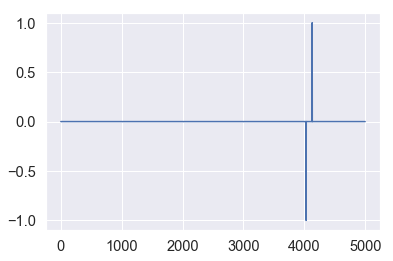

In [298]:
plt.plot(df_pop.columns, df_pop.loc[0] - best_indiv)
   

283


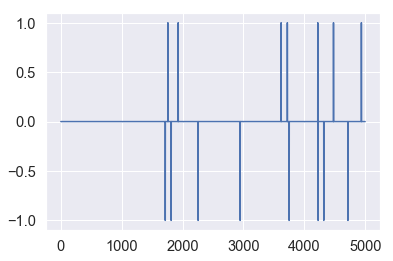

In [229]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop_surv.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])
   

283


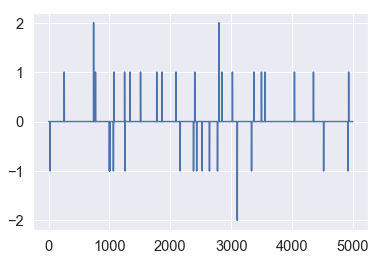

In [230]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])

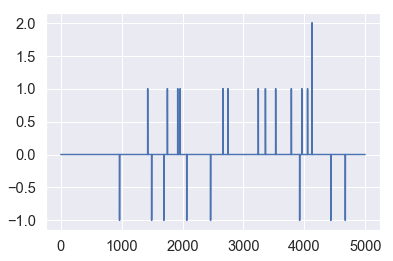

In [217]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

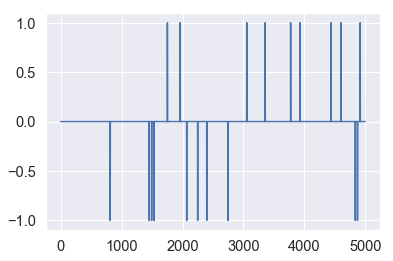

In [191]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

## From multiple baselines

### Find several baseline / seed source

#### Create ranges

In [52]:
submission = pd.read_csv(fpath, index_col='family_id')

In [53]:
submission.shape[0]

5000

In [54]:
NB_FIRST_SEED = 10
df_range = pd.DataFrame(index=range(0, NB_FIRST_SEED), 
                        columns=range(0, submission.shape[0]))

df_range.loc[0] = np.array(range(0, submission.shape[0]))

df_range.loc[1] = np.array(range(submission.index.max(), 
                                 submission.index.min()-1, -1))  

#for indice in range(2, NB_FIRST_SEED):
    

In [55]:
start_pt = np.linspace(0, submission.shape[0], 
                       num=int((NB_FIRST_SEED)/2)+1, dtype="int")
start_pt = start_pt[1:-1]
start_pt

array([1000, 2000, 3000, 4000])

In [56]:
np.array(range(10,0,-1))

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [57]:
indice = 2
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                submission.shape[0])), 
               np.array(range(0, start_pt[st_id]))))

indice = 6
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = \
        np.concatenate((range(start_pt[st_id], 0-1, -1), 
                range(submission.shape[0]-1, start_pt[st_id], -1)))

df_range    

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,4999,4998,4997,4996,4995,4994,4993,4992,4991,4990,...,9,8,7,6,5,4,3,2,1,0
2,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,990,991,992,993,994,995,996,997,998,999
3,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
4,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
6,1000,999,998,997,996,995,994,993,992,991,...,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001
7,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,...,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
8,3000,2999,2998,2997,2996,2995,2994,2993,2992,2991,...,3010,3009,3008,3007,3006,3005,3004,3003,3002,3001
9,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,4010,4009,4008,4007,4006,4005,4004,4003,4002,4001


In [24]:
df_range.min().min()

0

In [25]:
df_range.max().max()

4999

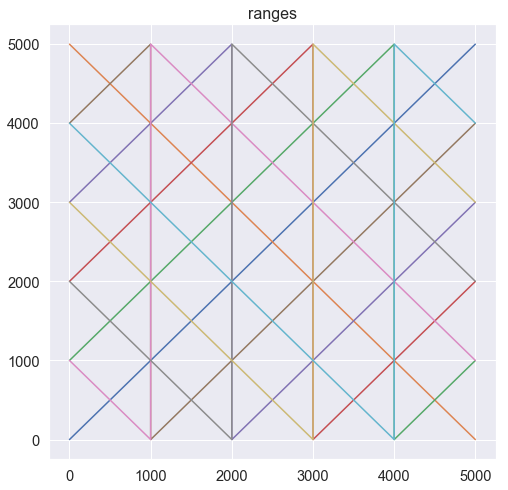

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.title("ranges")
for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[indice])


#### Evaluate baselines & save

In [449]:
t_fit_0 = time.time()
submission = pd.read_csv(fpath, index_col='family_id')
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)

for indice in df_range.index:
    # initiate first inviduate 
    new = best.copy()
    cost_best = start_cost
    # choose current range in df_range
    range_optim = df_range.loc[indice]
    # loop over each family with this current range
    for fam_id in range_optim:
        # loop over each family choice
        for pick in range(10):
            day = choice_dict[f'choice_{pick}'][fam_id]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            cost_curr = cost_function(temp) # test cost
            if cost_curr < cost_best:
                new = temp.copy()
                cost_best = cost_curr
                #print("Current best cost: ", cost_best)

    submission['assigned_day'] = new
    score = cost_function(new)
    submission.to_csv(f'submission_range{indice}.csv')
    print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022
Score: 657505.9426095837
Score: 677348.7683962411
Score: 605419.8337085167
Score: 656228.7546566363
Timing:  1473.9507336616516


### Generate first population

#### Method 1:  Day by days

In [27]:
df_range

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,4999,4998,4997,4996,4995,4994,4993,4992,4991,4990,...,9,8,7,6,5,4,3,2,1,0
2,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,990,991,992,993,994,995,996,997,998,999
3,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
4,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
6,1000,999,998,997,996,995,994,993,992,991,...,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001
7,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,...,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
8,3000,2999,2998,2997,2996,2995,2994,2993,2992,2991,...,3010,3009,3008,3007,3006,3005,3004,3003,3002,3001
9,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,4010,4009,4008,4007,4006,4005,4004,4003,4002,4001


In [88]:
# HYPERPARAMETERS
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop(seed_indiv=seed_indiv, nb_pop=nb_indiv_curr, 
                               r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  91.89893078804016
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  84.70671820640564
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  85.22644996643066
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  694.5717761516571
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  111.29203581809998
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  82.3056640625
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation populati

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
1,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
2,52,26,100,2,53,59,88,25,18,2,...,61,29,90,62,52,16,88,32,67,13
3,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
4,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


#### Save pop

In [141]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS),
           compress=True)

['../../data/df_pop1000_fs10_rfm0.01_dd3.pkl']

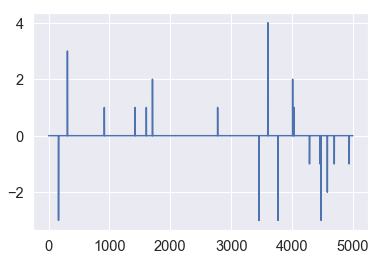

In [90]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [91]:
df_pop.describe()

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000
mean,56.001000,52.999000,99.998000,30.492000,52.994000,42.814000,71.211000,59.097000,22.196000,52.184000,...,56.706000,43.411000,27.59700,62.003000,53.405000,16.010000,67.609000,38.80100,79.506000,14.19500
std,22.875102,38.102583,0.063246,43.550713,0.141365,13.234748,33.633133,29.094434,12.608273,30.926471,...,8.773742,4.811989,31.21979,0.170353,2.797642,0.141138,31.183369,13.60016,12.502811,3.60527
min,38.000000,4.000000,98.000000,1.000000,50.000000,29.000000,1.000000,22.000000,16.000000,1.000000,...,47.000000,28.000000,9.00000,60.000000,51.000000,16.000000,20.000000,29.00000,67.000000,11.00000
25%,38.000000,26.000000,100.000000,2.000000,53.000000,32.000000,88.000000,25.000000,18.000000,50.000000,...,47.000000,45.000000,12.00000,62.000000,52.000000,16.000000,20.000000,32.00000,67.000000,13.00000
50%,52.000000,26.000000,100.000000,2.000000,53.000000,32.000000,88.000000,48.000000,18.000000,50.000000,...,61.000000,45.000000,12.00000,62.000000,52.000000,16.000000,88.000000,32.00000,81.000000,13.00000
75%,52.000000,99.000000,100.000000,97.000000,53.000000,59.000000,88.000000,93.000000,18.000000,88.000000,...,61.000000,45.000000,12.00000,62.000000,52.000000,16.000000,88.000000,32.00000,92.000000,13.00000
max,100.000000,100.000000,100.000000,97.000000,54.000000,62.000000,91.000000,95.000000,60.000000,91.000000,...,77.000000,47.000000,91.00000,65.000000,59.000000,18.000000,91.000000,66.00000,93.000000,25.00000


#### Method 2:  Choice by Choices

In [432]:
def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        
        vect_pop_mutated = mutation_day(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [433]:
# HYPERPARAMETERS
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

#df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop_choices(seed_indiv=seed_indiv, 
                                       nb_pop=nb_indiv_curr, 
                                       r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  53.41584396362305
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.22392964363098
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  44.29747796058655
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.89790415763855
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  45.88465929031372
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  47.983644247055054
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation popu

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
1,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
2,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
3,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
4,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,4,13


#### Save pop

In [435]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE),
           compress=True)

['../../data/df_pop_choices1000_fs10_rfm0.01_dc1.pkl']

## Run with pop by choices

### Evaluation #1

In [805]:
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

In [806]:
NB_FIRST_SEED = 10
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE))

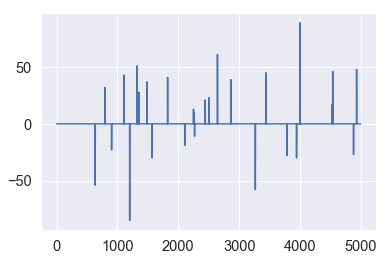

In [807]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [808]:
# create cost dataFrame for all population
t_1 = time.time()
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())
print(time.time()-t_1)

df_cost.sort_values(by="cost").head(10)


8.927010774612427


,cost
800,605419.833709
400,654844.718387
900,656228.754657
600,657505.942610
0,672254.027668
700,677348.768396
300,679410.167648
200,684479.327148
500,686524.150792
342,689530.226809


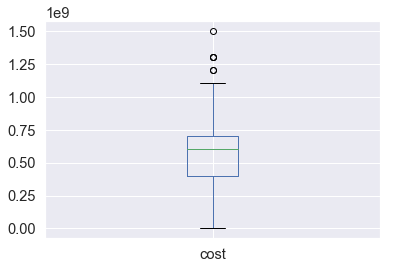

In [809]:
df_cost.boxplot()

###  Loop over generations

In [810]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.03# default 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 2
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    #t_lost_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 
    #t_lost_1 = time.time()
    #print("Timing lost: ", t_lost_1 - t_lost_0)
    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    #t_cross_0 = time.time()
    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)    
    #t_cross_1 = time.time()
    #print("Timing cross: ", t_cross_1 - t_cross_0)
    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    t_mut_0 = time.time()
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                mutation_day(df_pop.loc[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)
    #t_mut_1 = time.time()
    #print("Timing mutation: ", t_mut_1 - t_mut_0)
    ############
    # EVALUATION
    # create cost dataFrame for all population
    #t_eval_0 = time.time()
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    #t_eval_1 = time.time()
    #print("Timing eval: ", t_eval_1 - t_eval_0)
    
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)

    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

 
GENERATION #0 / nb. pop: 1000
nb_survivor:  970
Timing lost:  0.18298602104187012
Timing cross:  3.469944953918457
Timing mutation:  3.40529465675354
              cost
960  605419.833709
Timing eval:  9.002819061279297
Timing epoch:  16.06167483329773
 
GENERATION #1 / nb. pop: 970
nb_survivor:  940
Timing lost:  0.031132936477661133
Timing cross:  2.984985113143921
Timing mutation:  3.0325379371643066


KeyboardInterrupt: 

#### Save results

In [441]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dc1_rm0.1_gen20000_s434530.pkl']

In [ ]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 30000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 1
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                mutation_day(df_pop.loc[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

#### Save results

In [74]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dd5_rm0.1_gen30000.pkl']

## Run with pop by days

### Evaluation #1

In [60]:
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

In [61]:
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS))

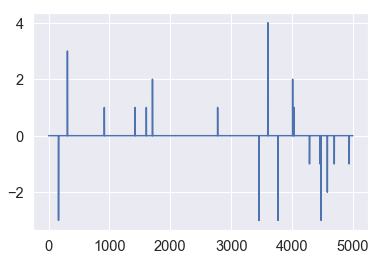

In [62]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [63]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

,cost
800,605419.833709
400,654844.718387
900,656228.754657
600,657505.942610
469,665206.371332
0,672254.027668
700,677348.768396
300,679410.167648
635,679441.505966
479,681538.723476


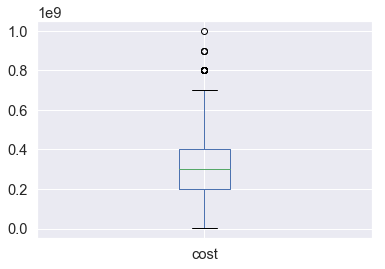

In [64]:
df_cost.boxplot()

###  Loop over generations

In [428]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_DAYS = 5
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

NameError: name 'cvpopo' is not defined

In [161]:
int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)

-2

In [ ]:
R_POP_LOST*df_cost_sort.shape[0]

#### Save results

In [74]:
# best score
#best_score = \
#cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + '/df_cost_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dd5_rm0.1_gen30000.pkl']

In [124]:

#df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name,:].to_csv("test.csv")

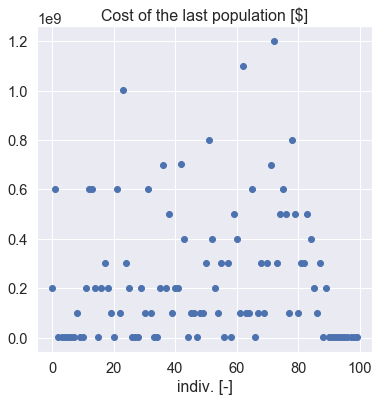

In [67]:
fig = plt.figure(figsize=(6, 6))
plt.title("Cost of the last population [$]")
plt.plot(df_cost["cost"], 'o')
ax = plt.gca()
ax.set_xlabel("indiv. [-]");
#ax.set_ylim([0 , 1e6])

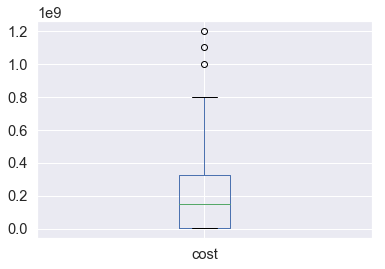

In [68]:
df_cost.boxplot()

In [72]:
cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

585102.5859791327

In [59]:
np.ceil(R_POP_LOST*df_cost_sort.shape[0])

10.0

In [60]:
nb_seeds

10

## Explore more

In [34]:
submission = pd.read_csv('submission_672254.0276683343.csv')
submission.head()

,family_id,assigned_day
0,0,52
1,1,26
2,2,100
3,3,2
4,4,53


In [40]:
cost_function(submission['assigned_day'].tolist(), True)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

In [36]:
# function submission -> choice number
list_choice=[]
for fam_id in submission["family_id"]:
    assigned_day = submission.at[fam_id, "assigned_day"]
    list_choice.append(np.argmax((data.filter(items=['choice_{}'.\
                                 format(n) for n in range(0, 10)]).\
        loc[fam_id] == assigned_day).tolist()))

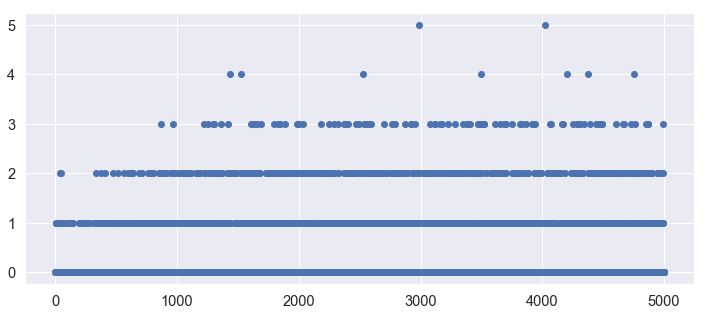

In [37]:
fig = plt.figure(figsize=(12, 5))
plt.plot(submission["family_id"], list_choice, 'o')

In [38]:
submission["choice"] = list_choice

In [39]:
submission["choice"].value_counts()

0    3535
1     946
2     416
3      94
4       7
5       2
Name: choice, dtype: int64